- Bike Sharing Demand Forecast (Keggle) https://www.kaggle.com/c/bike-sharing-demand/
- Referred to Potato's devlog (https://didu-story.tistory.com/43?category=937100)
- Referred to HONG_YP Data Science BLOG (https://hong-yp-ml-records.tistory.com/77?category=823206)


0. 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import scipy

In [3]:
train = pd.read_csv('/content/drive/MyDrive/PersonalWorks/BikeSharingDemandForecast/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PersonalWorks/BikeSharingDemandForecast/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/PersonalWorks/BikeSharingDemandForecast/sampleSubmission.csv')

1. 데이터확인

In [4]:
print(train.columns)
print(test.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
submit.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
# 날짜로 인식할 수 있게 설정
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
submit['datetime'] = pd.to_datetime(submit['datetime'])
train.info() # <- weather, season은 명목변수인만큼 추후 형 변환 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


2. EDA

*1) 카테고리형 변수 확인*

In [10]:
# 연/월/일/시/분/초 별 자전거 수요량 변화 시각화
# 주 단위도 확인하기 위해 datetime 패키지의 dayofweek도 확인

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train['dayofweek'] = train['datetime'].dt.dayofweek

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

test ['dayofweek'] = test['datetime'].dt.dayofweek

<Axes: xlabel='year', ylabel='count'>

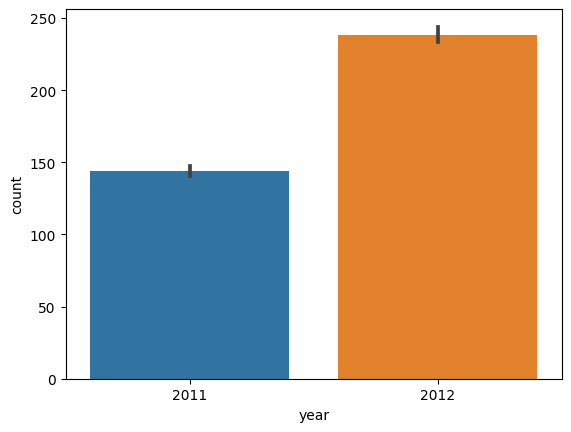

In [11]:
# 연도별
sns.barplot(x = 'year', y = 'count', data = train)

- 연도가 증가함에 따라 갑자기 수요량이 증가
- 하지만 표본이 두 개 밖에 없으므로 수요 증가의 **지속성** 여부는 알 수 없음
- *수요량이 증가했음*은 확인 가능하기에 year 변수를 사용할 수는 있을 것으로 판단

<Axes: xlabel='month', ylabel='count'>

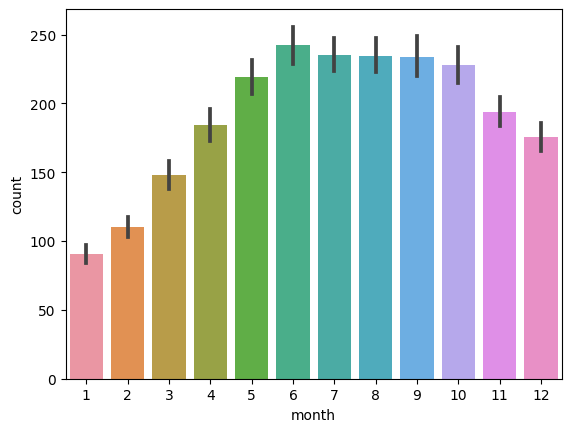

In [12]:
# 월별
sns.barplot(x = 'month', y = 'count', data = train)

- 상대적으로 1-3월은 자전거 수요량이 적음
- 상대적으로 6-9월은 자전거 수요량이 많음
- month 변수를 사용할 수 있을 것으로 판단

<Axes: xlabel='day', ylabel='count'>

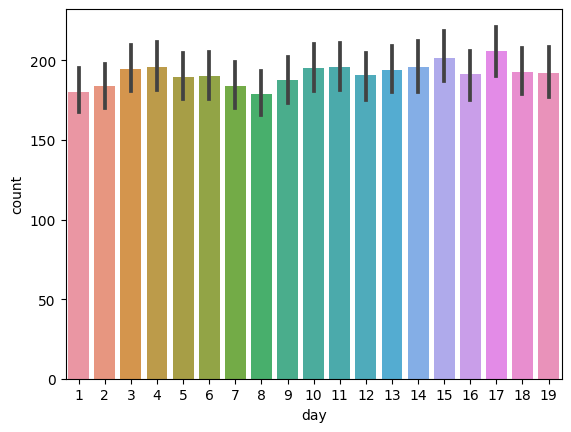

In [13]:
# 일별
sns.barplot(x = 'day', y = 'count', data = train)

- day별 자전거 수요량에 명백한 차이가 없기에 변수에거 제거하거나, 사용하지 않는게 좋을 것으로 판단

<Axes: xlabel='season', ylabel='count'>

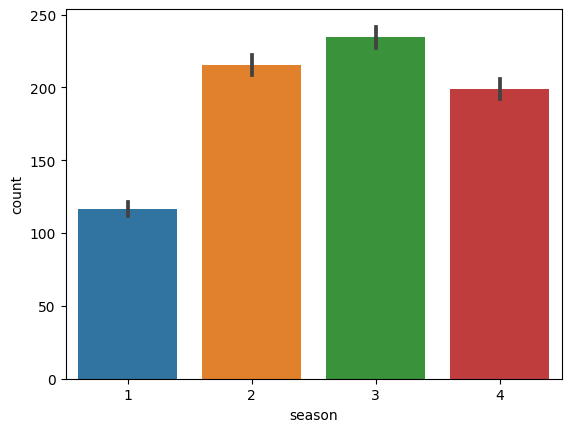

In [14]:
# 계절별
sns.barplot(x = 'season', y = 'count', data = train)

In [15]:
print(train[train['season'] == 1].month.unique())
print(train[train['season'] == 2].month.unique())
print(train[train['season'] == 3].month.unique())
print(train[train['season'] == 4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


- season 별 경계 확인
- season에 따른 수요량의 차이가 존재하기에, 변수로 활용 가능할 것으로 판단

<Axes: xlabel='hour', ylabel='count'>

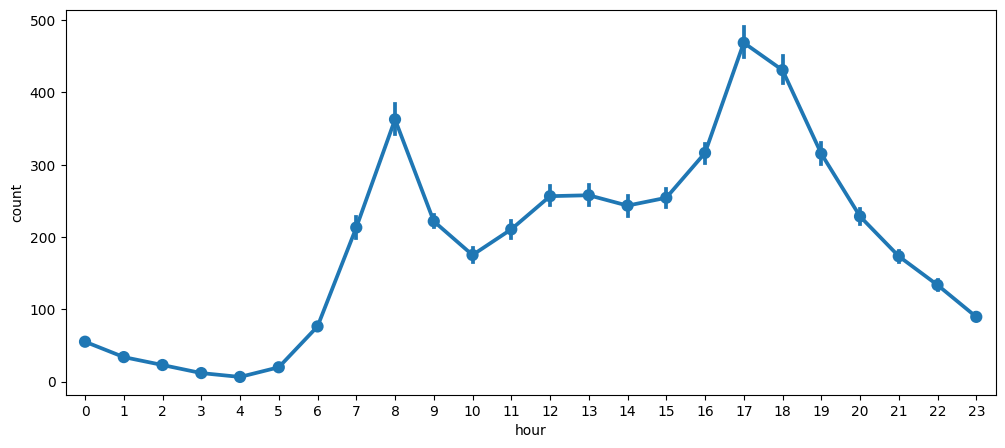

In [16]:
# 시별
plt.figure(figsize = (12,5))
sns.pointplot(x = 'hour', y = 'count', data = train)

- 시간대를 확인했을 때 8시, 17-18시에 이용이 가장 많음
- 출퇴근 시간 영향으로 유추

<Axes: xlabel='hour', ylabel='count'>

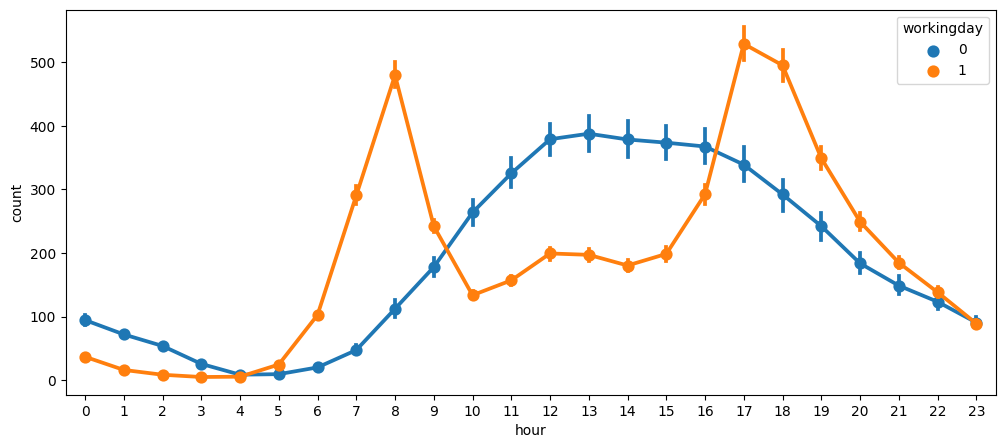

In [17]:
# workingday (카테고리형), 시간대별로 
plt.figure(figsize=(12,5))
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'workingday')

- 1:근무일 / 0: 근무일X
- 근무일에는 출퇴근 시간에 수요가 급증하고, 근무일이 아닌 날에는 오후 시간대에 수요가 완만하게 증가하는 것을 알 수 있다. 따라서 holiday 변수도 예측에 영향에 줄 것으로 예측

<Axes: xlabel='hour', ylabel='count'>

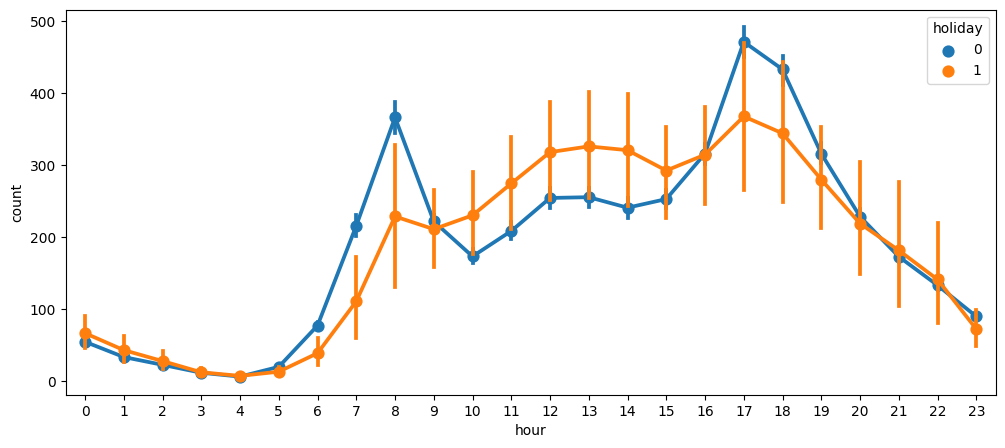

In [18]:
# holiday (카테고리형), 시간대별로 
plt.figure(figsize=(12,5))
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'holiday')

<Axes: xlabel='hour', ylabel='count'>

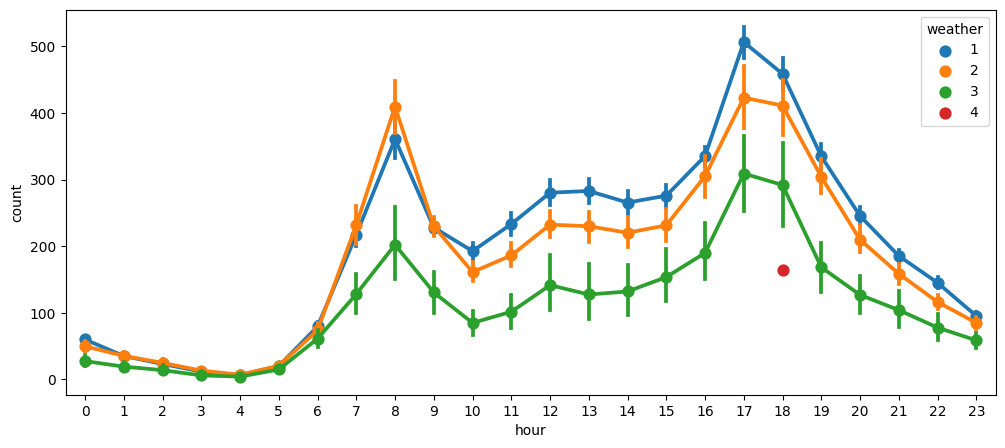

In [19]:
# weather (카테고리형), 시간대별로 point plot 확인
plt.figure(figsize=(12,5))
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weather')

- 1:매우맑음 / 2: 약간흐림 / 3: 약간눈비 / 4: 매우눈비
- 대체적으로 1>2>3>>4



<Axes: xlabel='hour', ylabel='count'>

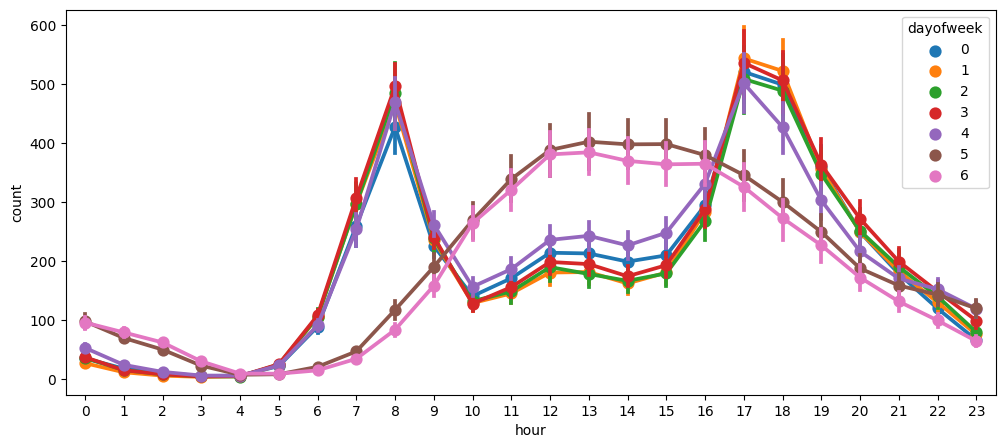

In [20]:
plt.figure(figsize = (12,5))
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'dayofweek')

- dayofweek의 양상은 평일끼리, 주말끼리 비슷하게 나타나지만 사용해보도록 함

결론적으로, **날짜 관련**은 아래의 변수들을 예측에 활용
1. year
2. month
3. day
4. hour
5. weather
6. holiday
7. workingday
8. dayofweek
9. season


*2) 변수간 상관관계*

In [21]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

<ipython-input-22-5e23cfb1540a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(corr_data.corr(),


<Axes: >

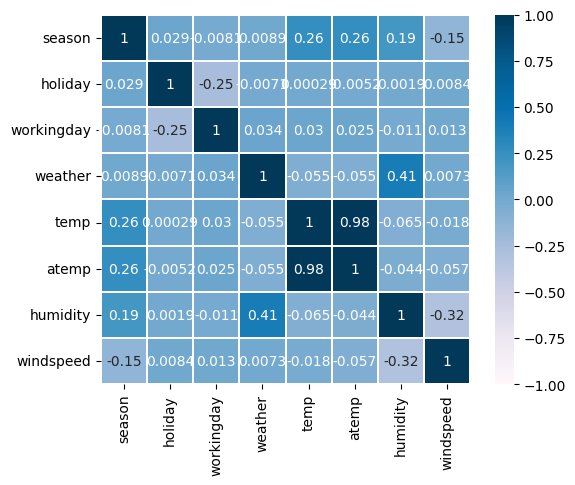

In [22]:
corr_data = train[['datetime', 'season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed']]
colormap = plt.cm.PuBu

sns.heatmap(corr_data.corr(), 
            linewidths = 0.1, 
            square = True, # 정사각형으로 
            annot = True, # 값 나타내기 
            vmin = -1, # 최소값: -1
            vmax = 1, # 최대값: +1
            cmap = colormap)

- temp와 atemp의 상관관계가 매우 높아서, 다중공선성이 의심되므로 temp 변수는 하나만 활용하는 것이 좋아보임

<Axes: xlabel='humidity', ylabel='count'>

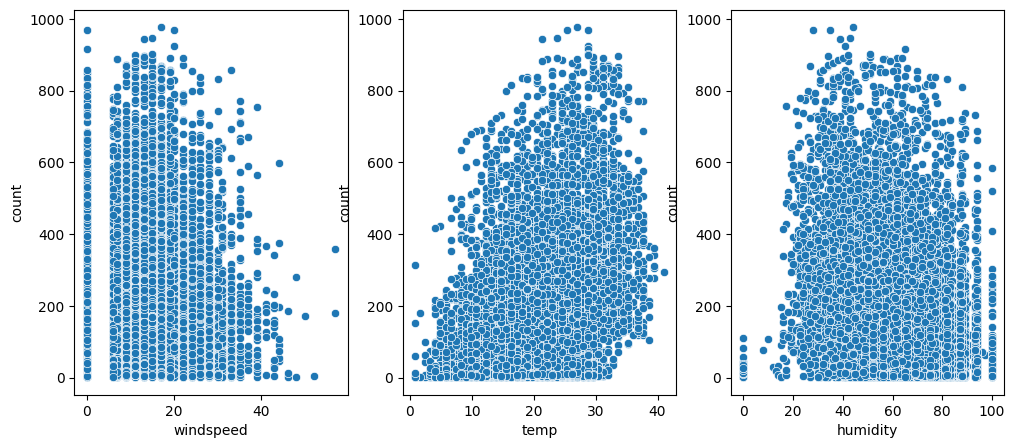

In [23]:
# 풍속, 기온, 습도 살펴보기
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (12,5))

sns.scatterplot(x = 'windspeed', y = 'count', data = train, ax = ax1)
sns.scatterplot(x = 'temp', y = 'count', data = train, ax = ax2)
sns.scatterplot(x = 'humidity', y = 'count', data = train, ax = ax3)

- HONG_YP님의 블로그: '풍속이 0인 경우의 실재 여부'를 생각해보며, 정규화 필요성을 감지

In [24]:
print(len(train[train['windspeed']==0]))
print(round((len(train[train['windspeed']==0])/len(train)),3),'%')

1313
0.121 %


3. 전처리

1) 이상치제거

<Axes: xlabel='count'>

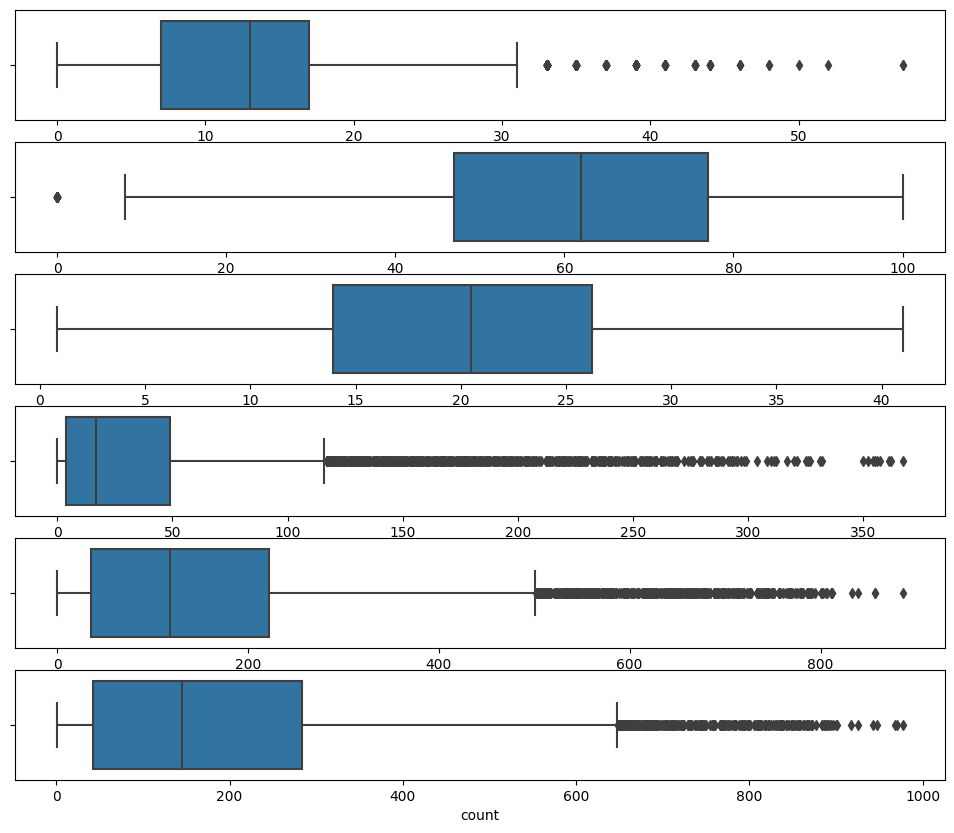

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12,10))

sns.boxplot(x = 'windspeed', data = train, ax = ax1)
sns.boxplot(x = 'humidity', data = train, ax = ax2)
sns.boxplot(x = 'temp', data = train, ax = ax3)
sns.boxplot(x = 'casual', data = train, ax = ax4)
sns.boxplot(x = 'registered', data = train, ax = ax5)
sns.boxplot(x = 'count', data = train, ax = ax6)

In [26]:
def get_outlier(df = None, column = None, weight = 1.5):
  Q1 = np.percentile(df[column].values, 25)
  Q3 = np.percentile(df[column].values, 75)

  IQR = Q3 - Q1
  IQR_weight = IQR * weight

  lowest = Q1 - IQR_weight
  highest = Q3 + IQR_weight

  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

- 이상치제거 코드 (IQT)

In [27]:
# 이상치 제거 전
train.shape

(10886, 19)

In [28]:
OSlists = ['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']

for OSlist in OSlists:
  outlier_idx = get_outlier(df = train, column = OSlist, weight = 1.5)
  train.drop(outlier_idx, axis=0, inplace=True)

In [29]:
# 이상치 제거 후
train.shape

(9360, 19)

- 이상치 데이터 1526개 제거

2) 왜도 & 첨도 확인
- 왜도 기준 : <|1|
- 첨도 기준 : <|7|

<ipython-input-30-3f1c7ee9c352>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  graph = sns.distplot(train['count'],


Skewness(왜도): 0.773608
Kurtosis(첨도): -0.239234


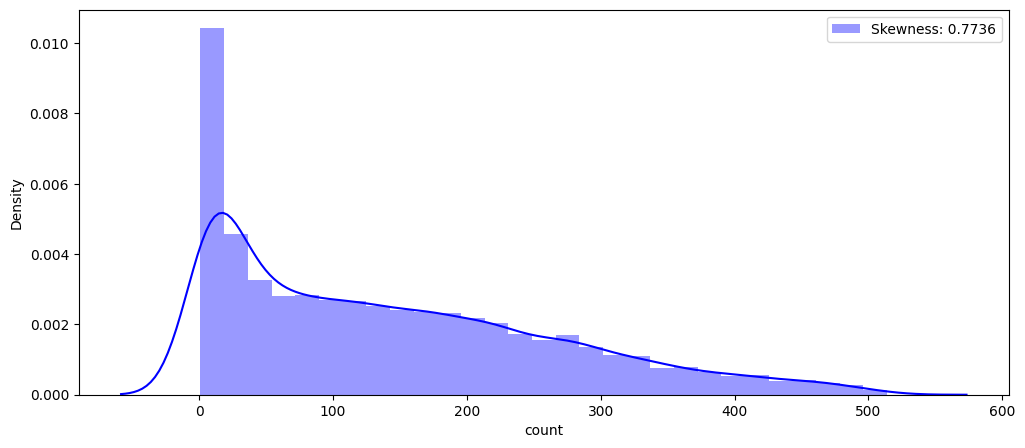

In [30]:
plt.figure(figsize = (12,5))

graph = sns.distplot(train['count'],
                     color = 'b',
                     label = 'Skewness: %.4f' %train['count'].skew())

graph = graph.legend(loc = 'best')

print('Skewness(왜도): %f' %train['count'].skew())
print('Kurtosis(첨도): %f' %train['count'].kurt())


- 데이터가 0에 매우 치우져 있음 
- Log Scaling을 통해 정규화 시키는 것이 좋아보임
- 주의: count에 Log를 취하는 것이니, 마지막에 나온 예측 결과값에 다시 Log를 취해줘야 원래 원하던 값이 나옴

<ipython-input-31-0cd449c9fc71>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  graph = sns.distplot(train['count_log'],


Skewness(왜도): 0.773608
Kurtosis(첨도): -0.239234


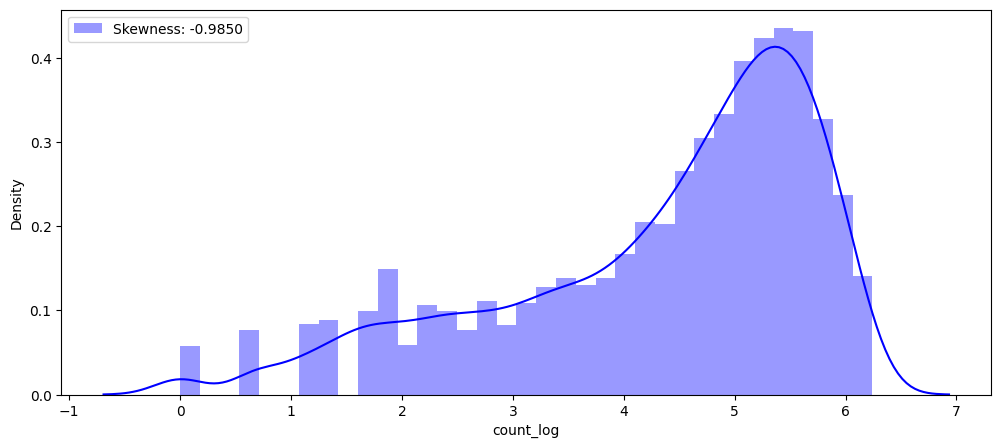

In [31]:
# lambda를 사용해서 로그를 취해준 count 값을 count_log 컬럼으로 생성
train['count_log'] = train['count'].map(lambda i:np.log(i) if i>0 else 0)

plt.figure(figsize = (12,5))
graph = sns.distplot(train['count_log'],
                     color = 'b',
                     label = 'Skewness: %.4f' %train['count_log'].skew())
graph = graph.legend(loc = 'best')

print('Skewness(왜도): %f' %train['count'].skew())
print('Kurtosis(첨도): %f' %train['count'].kurt())

In [32]:
train.drop('count', axis = 1, inplace = True)

3) Windspeed = 0 대체값 찾기
* RandomForest를 활용하여 예측된 값으로 windspeed = 0.0 값을 대체

In [33]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
  wind0 = data.loc[data['windspeed'] == 0]
  windnot0 = data.loc[data['windspeed'] != 0]

  # 풍속은 날씨 변수이기 때문에 날씨 변수를 활용해서 windspeed를 예측
  col = ['season', 'weather', 'temp', 'humidity', 'atemp', 'day']
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')

  rf = RandomForestClassifier()
  rf.fit(windnot0[col], windnot0['windspeed'])

  # windspeed가 0인 부분을 예측
  pred_wind0 = rf.predict(X = wind0[col])

  # wind0의 windspeed 값을 pred_wind0으로 바꿔주고
  wind0['windspeed'] = pred_wind0

  # windnot0과 wind0을 합침
  data = windnot0.append(wind0)
  data['windspeed'] = data['windspeed'].astype('float')

  data.reset_index(inplace = True)
  data.drop('index', inplace = True, axis = 1)

  return data

In [34]:
train = predict_windspeed(train)
test = predict_windspeed(test)

<ipython-input-33-441a1341fc58>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')
<ipython-input-33-441a1341fc58>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0['windspeed'] = pred_wind0
<ipython-input-33-441a1341fc58>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = windnot0.append(wind0)
<ipython-input-33-441a1341fc58>:9: SettingWithCopyWarnin

In [35]:
train[train['windspeed'] == 0.0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour,minute,second,dayofweek,count_log


<Axes: xlabel='windspeed', ylabel='count'>

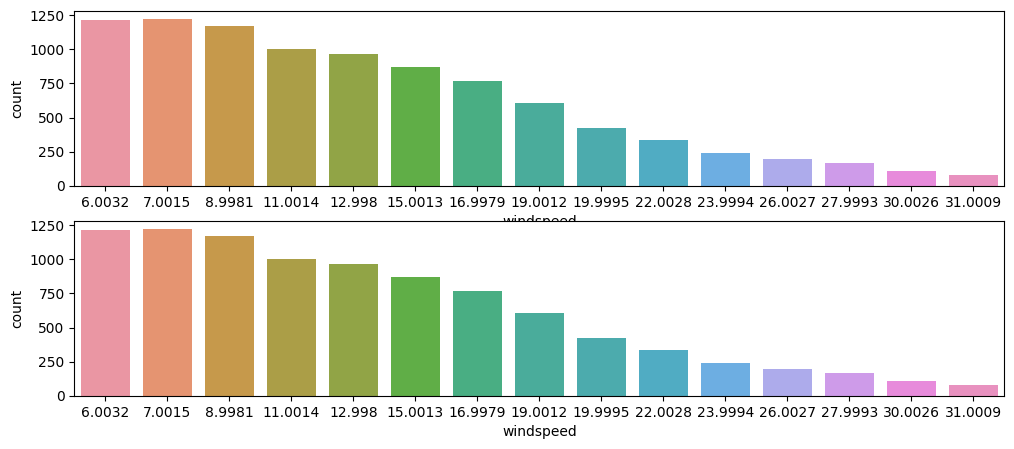

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (12,5))

sns.countplot(x = 'windspeed', data = train, ax = ax1)
sns.countplot(x = 'windspeed', data = train, ax = ax2)

4) Encoding (One-hot) 으로 범주형 변수 처리
- season : 봄(1), 여름(2), 가을(3), 겨울(4)
- holiday : 공휴일X(0), 공휴일O(1)
- workingday : 근무일X(0), 근무일O(1)
- weather : 매우맑음(1), 약간흐림(2), 약간눈비(3), 매우눈비(4)


In [37]:
# prefix : 변수 생성명 앞에 weather_1 이런식으로 생성
train = pd.get_dummies(train, columns = ['weather'], prefix = 'weather')
test = pd.get_dummies(test, columns = ['weather'], prefix = 'weather')

train = pd.get_dummies(train, columns = ['season'], prefix = 'season')
test = pd.get_dummies(test, columns = ['season'], prefix = 'season')

train = pd.get_dummies(train, columns = ['holiday'], prefix = 'holiday')
test = pd.get_dummies(test, columns = ['holiday'], prefix = 'holiday')

train = pd.get_dummies(train, columns = ['workingday'], prefix = 'workingday')
test = pd.get_dummies(test, columns = ['workingday'], prefix = 'workingday')

- 다음부터는 함수로 해야겠다

In [38]:
# 범주형 변수 처리 원핫 인코딩

def CatOneHot(data, columns, prefix = True):
  data = pd.get_dummies(data, columns = [columns], prefix = columns)

In [39]:
train.columns

Index(['datetime', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'dayofweek', 'count_log', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1'],
      dtype='object')

4. 모델링

1) 변수정리


In [40]:
test_datetime = test['datetime']

train.drop(['datetime', 'atemp', 'registered', 'casual', 'minute', 'second'], axis = 1, inplace = True)
test.drop(['datetime', 'atemp', 'minute', 'second'], axis = 1, inplace = True)

In [41]:
train.columns

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'count_log', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1'],
      dtype='object')

In [42]:
test.columns

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1', 'workingday_0', 'workingday_1'],
      dtype='object')

2) Gradient Boosting 학습

In [43]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# df가 아닌, array 형태여야하기 때문에 values를 취해줌
x_train = train.drop('count_log', axis = 1).values
target_label = train['count_log'].values
x_test = test.values

x_train, x_val, y_train, y_val = train_test_split(x_train, target_label, test_size = 0.2, random_state = 2000)

In [44]:
#x_train
#x_val
#y_train
#y_val

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(
    n_estimators = 2000,
    learning_rate = 0.05,
    max_depth = 5,
    min_samples_leaf = 15,
    min_samples_split = 10,
    random_state = 42
    )
regressor.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

In [46]:
score_train = regressor.score(x_train, y_train)
score_val = regressor.score(x_val, y_val)

print("train score: %f" %score_train)
print("validation score: %f" %score_val)

train score: 0.987179
validation score: 0.948762


5. 예측 및 submission.csv 생성

In [47]:
pred = regressor.predict(x_test)

sample = pd.read_csv('/content/drive/MyDrive/PersonalWorks/BikeSharingDemandForecast/sampleSubmission.csv')
sample.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [48]:
submission = pd.DataFrame()
submission['datetime'] = test_datetime
submission['count_log'] = pred

submission['count'] = np.exp(submission['count_log'])
submission.drop('count_log', axis = 1, inplace=True)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,11.927770
1,2011-01-20 03:00:00,1.716525
2,2011-01-20 04:00:00,1.331370
3,2011-01-20 05:00:00,4.791478
4,2011-01-20 06:00:00,30.402924


In [49]:
submission.to_csv('Bike.csv', index = False)